**Collecte des données**

In [44]:
# Collecte et préparation des séries : indices + VIX (2010-2025)
from pathlib import Path
import yfinance as yf
import pandas as pd
import numpy as np
import time

# Tickes: S&P500 + 5 indices choisis (HSI pour Hong Kong)
tickers = ["^GSPC", "^GDAXI", "^N225", "^BVSP", "^NSEI", "^HSI"]
start = "2010-01-01"
end = "2025-12-31"

# Détecter automatiquement la racine du dépôt en cherchant l'énoncé
cwd = Path.cwd()
repo_root = None
for p in [cwd] + list(cwd.parents):
    if (p / 'Enonce_EtudeCas1.md').exists():
        repo_root = p
        break
if repo_root is None:
    repo_root = cwd
data_dir = repo_root / 'data'
data_dir.mkdir(parents=True, exist_ok=True)
print('Data directory:', data_dir)

# Télécharger chaque série d'indice et créer un fichier avec prix + rendements
all_prices = []
all_returns = []

for t in tickers:
    print('Downloading', t)
    try:
        df = yf.download(t, start=start, end=end, progress=False, auto_adjust=True)
    except Exception as e:
        print('Download error for', t, e)
        continue
    if df is None or df.empty:
        print('Warning: no data for', t)
        continue
    
    # Préférer 'Adj Close' si disponible
    if 'Adj Close' in df.columns:
        prices = df['Adj Close'].copy()
    elif 'Close' in df.columns:
        prices = df['Close'].copy()
    else:
        prices = df.iloc[:, 0].copy()
    
    # S'assurer que les prix sont en float et triés
    prices = prices.astype(float).sort_index()
    
    # Calculer les rendements logarithmiques
    returns = np.log(prices).diff()
    
    # Créer un DataFrame avec prix et rendements pour cet indice
    ticker_clean = t.replace('^', '').replace('.', '_')
    
    # Créer le DataFrame en utilisant l'index des prix
    combined_df = pd.DataFrame(index=prices.index)
    combined_df['Price'] = prices
    combined_df['Returns'] = returns
    combined_df.index.name = 'Date'
    
    # Sauvegarder le fichier combiné pour cet indice
    fname = f"{ticker_clean}.csv"
    path = data_dir / fname
    combined_df.to_csv(path)
    print(f'Saved {ticker_clean}: {path} (rows={len(combined_df)})')
    
    # Garder pour les fichiers merged séparés
    prices.name = ticker_clean
    returns_clean = returns.dropna()
    returns_clean.name = ticker_clean
    all_prices.append(prices)
    all_returns.append(returns_clean)
    
    time.sleep(1.0)

# Créer les fichiers merged séparés : prix ET rendements
if all_prices:
    # 1. Fichier merged PRIX seulement
    merged_prices = pd.concat(all_prices, axis=1).sort_index()
    merged_prices_path = data_dir / 'merged_prices.csv'
    merged_prices.to_csv(merged_prices_path)
    print(f'Merged PRICES saved: {merged_prices_path}')
    
    # 2. Fichier merged RENDEMENTS seulement (inner join pour dates communes)
    merged_returns = pd.concat(all_returns, axis=1, join="inner").sort_index()
    merged_returns_path = data_dir / 'merged_returns.csv'
    merged_returns.to_csv(merged_returns_path)
    print(f'Merged RETURNS saved: {merged_returns_path}')

# Télécharger et traiter VIX de la même manière
print('Downloading ^VIX')
try:
    vix_df = yf.download('^VIX', start=start, end=end, progress=False, auto_adjust=True)
    if vix_df is not None and not vix_df.empty:
        if 'Adj Close' in vix_df.columns:
            vix_prices = vix_df['Adj Close'].copy()
        elif 'Close' in vix_df.columns:
            vix_prices = vix_df['Close'].copy()
        else:
            vix_prices = vix_df.iloc[:, 0].copy()
        
        # S'assurer que VIX est en float et trié
        vix_prices = vix_prices.astype(float).sort_index()
        
        # Calculer rendements VIX
        vix_returns = np.log(vix_prices).diff()
        
        # Fichier VIX individuel
        vix_combined = pd.DataFrame(index=vix_prices.index)
        vix_combined['Price'] = vix_prices
        vix_combined['Returns'] = vix_returns
        vix_combined.index.name = 'Date'
        vix_path = data_dir / 'VIX.csv'
        vix_combined.to_csv(vix_path)
        print(f'Saved VIX: {vix_path} (rows={len(vix_combined)})')
        
        # Ajouter VIX au fichier merged PRIX
        if merged_prices_path.exists():
            merged_prices = pd.read_csv(merged_prices_path, index_col=0, parse_dates=True)
            merged_prices['VIX'] = vix_prices.reindex(merged_prices.index)
            merged_prices.to_csv(merged_prices_path)
            print(f'VIX added to merged prices: {merged_prices_path}')
        
        # Ajouter VIX au fichier merged RENDEMENTS (alignement sur dates communes)
        if merged_returns_path.exists():
            merged_returns = pd.read_csv(merged_returns_path, index_col=0, parse_dates=True)
            # Aligner VIX sur les dates communes des rendements
            vix_returns_aligned = vix_returns.reindex(merged_returns.index)
            merged_returns['VIX'] = vix_returns_aligned
            merged_returns.to_csv(merged_returns_path)
            print(f'VIX added to merged returns: {merged_returns_path}')
            
            # Créer aussi un fichier avec VIX niveaux pour régression corr~log(VIX)
            vix_levels_path = data_dir / 'vix_levels_aligned.csv'
            vix_levels_aligned = vix_prices.reindex(merged_returns.index)
            vix_levels_aligned.to_csv(vix_levels_path)
            print(f'VIX levels (for regression) saved: {vix_levels_path}')
    else:
        print('Warning: no VIX data downloaded')
except Exception as e:
    print('VIX download error:', e)

print("\n=== Fichiers créés ===")
print("Structure: Chaque indice = 1 fichier (Price + Returns)")
print("Fichier merged PRIX:", merged_prices_path.name if 'merged_prices_path' in locals() else "Non créé")
print("Fichier merged RENDEMENTS:", merged_returns_path.name if 'merged_returns_path' in locals() else "Non créé")
print("VIX niveaux alignés:", 'vix_levels_aligned.csv' if 'vix_levels_path' in locals() else "Non créé")
if data_dir.exists():
    csv_files = list(data_dir.glob('*.csv'))
    print(f"Total fichiers CSV: {len(csv_files)}")
    for f in sorted(csv_files):
        print(f"  - {f.name}")

Data directory: c:\Users\Administrator\OneDrive - HEC Montréal\Documents\GitHub\-tude-de-cas-1-\data


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arrays\datetimes.py:666: ResourceWarning: unclosed database in <sqlite3.Connection object at 0x000002453DF5CD60>
  converted = ints_to_pydatetime(


Saved GSPC: c:\Users\Administrator\OneDrive - HEC Montréal\Documents\GitHub\-tude-de-cas-1-\data\GSPC.csv (rows=3987)


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arrays\datetimes.py:666: ResourceWarning: unclosed database in <sqlite3.Connection object at 0x000002453DF5CD60>
  converted = ints_to_pydatetime(


Saved GDAXI: c:\Users\Administrator\OneDrive - HEC Montréal\Documents\GitHub\-tude-de-cas-1-\data\GDAXI.csv (rows=4024)


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arrays\datetimes.py:666: ResourceWarning: unclosed database in <sqlite3.Connection object at 0x000002453DF5CD60>
  converted = ints_to_pydatetime(


Saved N225: c:\Users\Administrator\OneDrive - HEC Montréal\Documents\GitHub\-tude-de-cas-1-\data\N225.csv (rows=3876)


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arrays\datetimes.py:666: ResourceWarning: unclosed database in <sqlite3.Connection object at 0x000002453DF5CD60>
  converted = ints_to_pydatetime(


Saved BVSP: c:\Users\Administrator\OneDrive - HEC Montréal\Documents\GitHub\-tude-de-cas-1-\data\BVSP.csv (rows=3930)
Saved NSEI: c:\Users\Administrator\OneDrive - HEC Montréal\Documents\GitHub\-tude-de-cas-1-\data\NSEI.csv (rows=3891)
Saved NSEI: c:\Users\Administrator\OneDrive - HEC Montréal\Documents\GitHub\-tude-de-cas-1-\data\NSEI.csv (rows=3891)


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arrays\datetimes.py:666: ResourceWarning: unclosed database in <sqlite3.Connection object at 0x000002453DF5CD60>
  converted = ints_to_pydatetime(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arrays\datetimes.py:666: ResourceWarning: unclosed database in <sqlite3.Connection object at 0x000002453DF5E020>
  converted = ints_to_pydatetime(


Saved HSI: c:\Users\Administrator\OneDrive - HEC Montréal\Documents\GitHub\-tude-de-cas-1-\data\HSI.csv (rows=3901)
Merged PRICES saved: c:\Users\Administrator\OneDrive - HEC Montréal\Documents\GitHub\-tude-de-cas-1-\data\merged_prices.csv
Merged RETURNS saved: c:\Users\Administrator\OneDrive - HEC Montréal\Documents\GitHub\-tude-de-cas-1-\data\merged_returns.csv
Merged PRICES saved: c:\Users\Administrator\OneDrive - HEC Montréal\Documents\GitHub\-tude-de-cas-1-\data\merged_prices.csv
Merged RETURNS saved: c:\Users\Administrator\OneDrive - HEC Montréal\Documents\GitHub\-tude-de-cas-1-\data\merged_returns.csv


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arrays\datetimes.py:666: ResourceWarning: unclosed database in <sqlite3.Connection object at 0x000002453DF5C4F0>
  converted = ints_to_pydatetime(


Saved VIX: c:\Users\Administrator\OneDrive - HEC Montréal\Documents\GitHub\-tude-de-cas-1-\data\VIX.csv (rows=3987)
VIX added to merged prices: c:\Users\Administrator\OneDrive - HEC Montréal\Documents\GitHub\-tude-de-cas-1-\data\merged_prices.csv
VIX added to merged returns: c:\Users\Administrator\OneDrive - HEC Montréal\Documents\GitHub\-tude-de-cas-1-\data\merged_returns.csv
VIX levels (for regression) saved: c:\Users\Administrator\OneDrive - HEC Montréal\Documents\GitHub\-tude-de-cas-1-\data\vix_levels_aligned.csv

=== Fichiers créés ===
Structure: Chaque indice = 1 fichier (Price + Returns)
Fichier merged PRIX: merged_prices.csv
Fichier merged RENDEMENTS: merged_returns.csv
VIX niveaux alignés: vix_levels_aligned.csv
Total fichiers CSV: 16
  - ar_approach_comparison.csv
  - ar_models_results.csv
  - BVSP.csv
  - correlation_statistics.csv
  - correlations_126days.csv
  - GDAXI.csv
  - GSPC.csv
  - HSI.csv
  - merged_indices.csv
  - merged_prices.csv
  - merged_returns.csv
  - N225.

**2.1.1 - Corrélations mobiles 126 jours**

Données: 3260 observations, 6 indices
Période: 2010-01-05 à 2025-11-06

Calcul corrélations mobiles avec ^GSPC...
Résultat: 3135 observations de corrélations

=== Statistiques des corrélations ===
                 ^GDAXI     ^N225     ^BVSP     ^NSEI      ^HSI
Nombre         3135.000  3135.000  3135.000  3135.000  3135.000
Moyenne           0.550     0.163     0.482     0.230     0.189
Écart-type        0.142     0.121     0.179     0.119     0.118
Minimum           0.040    -0.141     0.021    -0.042    -0.092
1er quartile      0.486     0.082     0.367     0.145     0.093
Médiane           0.542     0.153     0.452     0.229     0.192
3ème quartile     0.669     0.254     0.582     0.304     0.267
Maximum           0.839     0.607     0.910     0.627     0.472


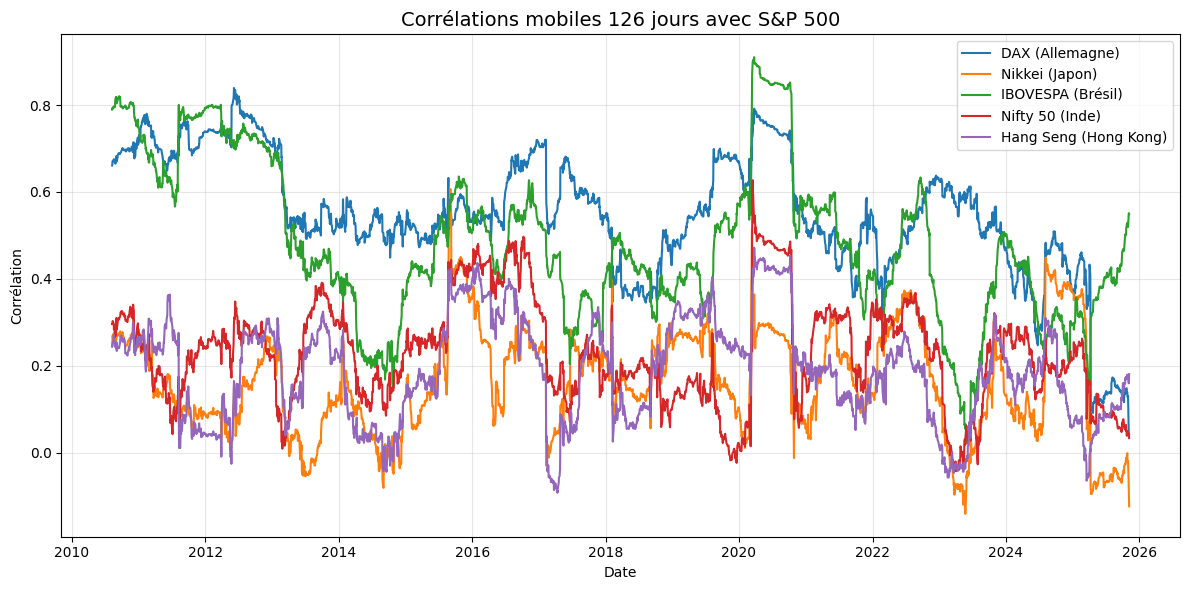


=== Corrélations moyennes ===
DAX (Allemagne)     : 0.550
IBOVESPA (Brésil)   : 0.482
Nifty 50 (Inde)     : 0.230
Hang Seng (Hong Kong): 0.189
Nikkei (Japon)      : 0.163

Fichier sauvegardé: correlations_126days.csv


In [45]:
# 2.1.1 - Calcul des corrélations mobiles 126 jours entre S&P 500 et indices internationaux
import numpy as np
import matplotlib.pyplot as plt

# Charger les données de rendements
returns = pd.read_csv(data_dir / 'merged_returns.csv', index_col=0, parse_dates=True)
stock_returns = returns.drop('VIX', axis=1) if 'VIX' in returns.columns else returns.copy()

print(f"Données: {stock_returns.shape[0]} observations, {stock_returns.shape[1]} indices")
print(f"Période: {stock_returns.index[0].date()} à {stock_returns.index[-1].date()}")

# Identifier S&P 500 et calculer corrélations mobiles 126 jours
sp500_col = [col for col in stock_returns.columns if 'GSPC' in col][0]
sp500_returns = stock_returns[sp500_col]
rolling_window = 126

print(f"\nCalcul corrélations mobiles avec {sp500_col}...")
correlations = {}
for col in stock_returns.columns:
    if col != sp500_col:
        correlations[col] = stock_returns[col].rolling(window=rolling_window).corr(sp500_returns)

# Créer DataFrame et nettoyer
corr_df = pd.DataFrame(correlations).dropna()
print(f"Résultat: {corr_df.shape[0]} observations de corrélations")

# Sauvegarder
corr_path = data_dir / 'correlations_126days.csv'
corr_df.to_csv(corr_path)

# Statistiques descriptives
print(f"\n=== Statistiques des corrélations ===")
stats_desc = corr_df.describe().round(3)
# Traduire les index en français
stats_desc.index = ['Nombre', 'Moyenne', 'Écart-type', 'Minimum', '1er quartile', 'Médiane', '3ème quartile', 'Maximum']
print(stats_desc)

# Graphique simplifié
markets = {
    '^GDAXI': 'DAX (Allemagne)', '^N225': 'Nikkei (Japon)', 
    '^BVSP': 'IBOVESPA (Brésil)', '^NSEI': 'Nifty 50 (Inde)', '^HSI': 'Hang Seng (Hong Kong)'
}

plt.figure(figsize=(12, 6))
for col in corr_df.columns:
    plt.plot(corr_df.index, corr_df[col], label=markets.get(col, col), linewidth=1.5)

plt.title('Corrélations mobiles 126 jours avec S&P 500', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Corrélation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Résumé par marché
print(f"\n=== Corrélations moyennes ===")
for market, corr in corr_df.mean().sort_values(ascending=False).items():
    print(f"{markets.get(market, market):20}: {corr:.3f}")

print(f"\nFichier sauvegardé: {corr_path.name}")

**2.1.2 - Tests de stationnarité (ADF et DF-GLS)**

In [46]:
# 2.1.2 - Tests de stationnarité robustes (ADF + Phillips-Perron + KPSS) + Tests ARCH/GARCH
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron
from arch import arch_model
from statsmodels.stats.diagnostic import het_arch
import pandas as pd

# Charger les corrélations calculées précédemment
corr_df = pd.read_csv(data_dir / 'correlations_126days.csv', index_col=0, parse_dates=True)

print("=== Tests de stationnarité des corrélations (Analyse complète) ===")
print("\n--- Tests de stationnarité (moyenne constante) ---")
print("H0 ADF: Série non-stationnaire (racine unitaire)")
print("H0 Phillips-Perron: Série non-stationnaire (racine unitaire)")
print("H0 KPSS: Série stationnaire")
print("\n--- Tests d'homoscédasticité (variance constante) ---")
print("H0 ARCH-LM: Pas d'effets ARCH (variance constante)")
print("Seuil significativité: 5%\n")

# Tableau des résultats
results = []

markets = {
    '^GDAXI': 'DAX (Allemagne)', '^N225': 'Nikkei (Japon)', 
    '^BVSP': 'IBOVESPA (Brésil)', '^NSEI': 'Nifty 50 (Inde)', '^HSI': 'Hang Seng (Hong Kong)'
}

for col in corr_df.columns:
    series = corr_df[col].dropna()
    market_name = markets.get(col, col)
    
    # Test ADF
    adf_stat, adf_pval, adf_lags, adf_nobs, adf_critical, adf_icbest = adfuller(series, autolag='AIC')
    adf_conclusion = "Stationnaire" if adf_pval < 0.05 else "Non-stationnaire"
    
    # Test Phillips-Perron
    pp_test = PhillipsPerron(series)
    pp_stat = pp_test.stat
    pp_pval = pp_test.pvalue
    pp_conclusion = "Stationnaire" if pp_pval < 0.05 else "Non-stationnaire"
    
    # Test KPSS  
    kpss_stat, kpss_pval, kpss_lags, kpss_critical = kpss(series, regression='c')
    kpss_conclusion = "Non-stationnaire" if kpss_pval < 0.05 else "Stationnaire"
    
    # Test ARCH-LM pour l'hétéroscédasticité
    try:
        # Calculer les résidus (série centrée pour le test ARCH)
        residuals = series - series.mean()
        # Test ARCH-LM (Engle's test)
        arch_stat, arch_pval, _, _ = het_arch(residuals, maxlag=5)
        arch_conclusion = "Hétéroscédastique" if arch_pval < 0.05 else "Homoscédastique"
        
        # Essayer d'ajuster un modèle GARCH si effets ARCH détectés
        garch_info = "Non estimé"
        if arch_pval < 0.05:
            try:
                # Modèle GARCH(1,1) sur les résidus
                garch_model = arch_model(residuals, vol='Garch', p=1, q=1, rescale=False)
                garch_fit = garch_model.fit(disp='off')
                # Extraire les paramètres principaux
                alpha = garch_fit.params.get('alpha[1]', 0)
                beta = garch_fit.params.get('beta[1]', 0)
                garch_info = f"α={alpha:.3f}, β={beta:.3f}"
            except:
                garch_info = "Échec estimation"
    except Exception as e:
        arch_pval = np.nan
        arch_conclusion = "Erreur test"
        garch_info = "Non disponible"
    
    # Règle de décision majoritaire
    stationary_votes = [
        adf_conclusion == "Stationnaire",
        pp_conclusion == "Stationnaire", 
        kpss_conclusion == "Stationnaire"
    ]
    
    stationary_count = sum(stationary_votes)
    
    if stationary_count == 3:
        combined = "Stationnaire (unanime)"
    elif stationary_count == 2:
        combined = "Stationnaire (majoritaire)"
    elif stationary_count == 1:
        combined = "Non-stationnaire (majoritaire)"
    else:
        combined = "Non-stationnaire (unanime)"
    
    results.append({
        'Marché': market_name,
        'ADF_pval': adf_pval,
        'ADF_conclusion': adf_conclusion,
        'PP_pval': pp_pval,
        'PP_conclusion': pp_conclusion,
        'KPSS_pval': kpss_pval,
        'KPSS_conclusion': kpss_conclusion,
        'ARCH_pval': arch_pval,
        'ARCH_conclusion': arch_conclusion,
        'GARCH_params': garch_info,
        'Votes_Stationnaire': f"{stationary_count}/3",
        'Conclusion': combined
    })

# Affichage des résultats
results_df = pd.DataFrame(results)

print("=== Résultats détaillés des tests ===")
for _, row in results_df.iterrows():
    print(f"\n{row['Marché']} ({row['Votes_Stationnaire']} votes stationnaire):")
    print(f"  ADF: p-val={row['ADF_pval']:.3f} -> {row['ADF_conclusion']}")
    print(f"  Phillips-Perron: p-val={row['PP_pval']:.3f} -> {row['PP_conclusion']}")
    print(f"  KPSS: p-val={row['KPSS_pval']:.3f} -> {row['KPSS_conclusion']}")
    if not pd.isna(row['ARCH_pval']):
        print(f"  ARCH-LM: p-val={row['ARCH_pval']:.3f} -> {row['ARCH_conclusion']}")
        if row['GARCH_params'] not in ['Non estimé', 'Non disponible', 'Échec estimation']:
            print(f"  GARCH(1,1): {row['GARCH_params']}")
    print(f"  -> Stationnarité: {row['Conclusion']}")

# Tableau résumé professionnel
print(f"\n" + "="*90)
print("TABLEAU RESUME - TESTS DE STATIONNARITE ET D'HOMOSCEDASTICITE")
print("="*90)

summary_table = results_df[['Marché', 'ADF_conclusion', 'PP_conclusion', 'KPSS_conclusion', 
                           'Conclusion', 'ARCH_conclusion']].copy()
summary_table.columns = ['Marché', 'ADF', 'Phillips-P', 'KPSS', 'Stationnarité (moyenne)', 'ARCH-LM']

# Affichage formaté du tableau avec le nouvel ordre
print(f"{'Marché':<20} {'ADF':<15} {'Phillips-P':<15} {'KPSS':<15} {'Stationnarité (moyenne)':<30} {'ARCH-LM':<15}")
print("-" * 110)
for _, row in summary_table.iterrows():
    print(f"{row['Marché']:<20} {row['ADF']:<15} {row['Phillips-P']:<15} {row['KPSS']:<15} {row['Stationnarité (moyenne)']:<30} {row['ARCH-LM']:<15}")

print("-" * 110)

# Statistiques par type de marché
developed = ['DAX (Allemagne)', 'Nikkei (Japon)']
emerging = ['IBOVESPA (Brésil)', 'Nifty 50 (Inde)', 'Hang Seng (Hong Kong)']

dev_results = results_df[results_df['Marché'].isin(developed)]
em_results = results_df[results_df['Marché'].isin(emerging)]

stationary_dev = (dev_results['Conclusion'].str.contains('Stationnaire')).sum()
stationary_em = (em_results['Conclusion'].str.contains('Stationnaire')).sum()
homosced_dev = (dev_results['ARCH_conclusion'] == 'Homoscédastique').sum()
homosced_em = (em_results['ARCH_conclusion'] == 'Homoscédastique').sum()

print(f"\n=== Statistiques par type de marché ===")
print(f"Marchés développés ({len(dev_results)} marchés):")
print(f"  - Stationnaires (moyenne): {stationary_dev}/{len(dev_results)}")
print(f"  - Homoscédastiques (variance): {homosced_dev}/{len(dev_results)}")

print(f"Marchés émergents ({len(em_results)} marchés):")
print(f"  - Stationnaires (moyenne): {stationary_em}/{len(em_results)}")
print(f"  - Homoscédastiques (variance): {homosced_em}/{len(em_results)}")

# Sauvegarder les résultats
results_path = data_dir / 'stationarity_arch_tests_complete.csv'
results_df.to_csv(results_path, index=False)
print(f"\nRésultats sauvegardés: {results_path.name}")

# Réactiver les warnings
warnings.filterwarnings('default')

=== Tests de stationnarité des corrélations (Analyse complète) ===

--- Tests de stationnarité (moyenne constante) ---
H0 ADF: Série non-stationnaire (racine unitaire)
H0 Phillips-Perron: Série non-stationnaire (racine unitaire)
H0 KPSS: Série stationnaire

--- Tests d'homoscédasticité (variance constante) ---
H0 ARCH-LM: Pas d'effets ARCH (variance constante)
Seuil significativité: 5%



=== Résultats détaillés des tests ===

DAX (Allemagne) (0/3 votes stationnaire):
  ADF: p-val=0.745 -> Non-stationnaire
  Phillips-Perron: p-val=0.651 -> Non-stationnaire
  KPSS: p-val=0.010 -> Non-stationnaire
  ARCH-LM: p-val=0.000 -> Hétéroscédastique
  GARCH(1,1): α=0.200, β=0.780
  -> Stationnarité: Non-stationnaire (unanime)

Nikkei (Japon) (3/3 votes stationnaire):
  ADF: p-val=0.004 -> Stationnaire
  Phillips-Perron: p-val=0.002 -> Stationnaire
  KPSS: p-val=0.100 -> Stationnaire
  ARCH-LM: p-val=0.000 -> Hétéroscédastique
  GARCH(1,1): α=0.200, β=0.780
  -> Stationnarité: Stationnaire (unanime)

IBOVESPA (Brésil) (1/3 votes stationnaire):
  ADF: p-val=0.039 -> Stationnaire
  Phillips-Perron: p-val=0.065 -> Non-stationnaire
  KPSS: p-val=0.010 -> Non-stationnaire
  ARCH-LM: p-val=0.000 -> Hétéroscédastique
  GARCH(1,1): α=0.200, β=0.780
  -> Stationnarité: Non-stationnaire (majoritaire)

Nifty 50 (Inde) (2/3 votes stationnaire):
  ADF: p-val=0.004 -> Stationnaire
  Phillips-Per

**2.2 - Modèles autorégressifs (AR) pour la prévision des corrélations**

=== SECTION 2.2: MODÈLES AUTORÉGRESSIFS (AR) - MÉTHODOLOGIE COMPLÈTE ===
Conformément au mandat: Test des DEUX approches (niveaux ET différences)
avec rolling forecasts, diagnostics et sélection optimale

CONFIGURATION:
• Échantillon: 3135 obs. | Train: 2508 (80%) | Test: 627 (20%)
• Période test: 2022-10-31 à 2025-11-06
• Lag max: 8 | Critère: AIC | Rolling one-step-ahead
• Diagnostics: Ljung-Box, Jarque-Bera, ARCH-LM

ESTIMATION PAR MARCHÉ (Format condensé):

DAX (Allemagne) (Stationnarité: NON)
------------------------------------------------------------
  NIVEAUX   : AR(1) | RMSE=0.0080 | R²=0.000
              Diagnostics: LB=✗ | JB=✗ | ARCH=✗
  NIVEAUX   : AR(1) | RMSE=0.0080 | R²=0.000
              Diagnostics: LB=✗ | JB=✗ | ARCH=✗
  DIFFÉRENCES: AR(1) | RMSE=0.0077 | R²=0.000
              Diagnostics: LB=✗ | JB=✗ | ARCH=✗
  → OPTIMAL : Différences | Amélioration: 4.0% | Cohérence: ✓

Nikkei (Japon) (Stationnarité: OUI)
---------------------------------------------------------

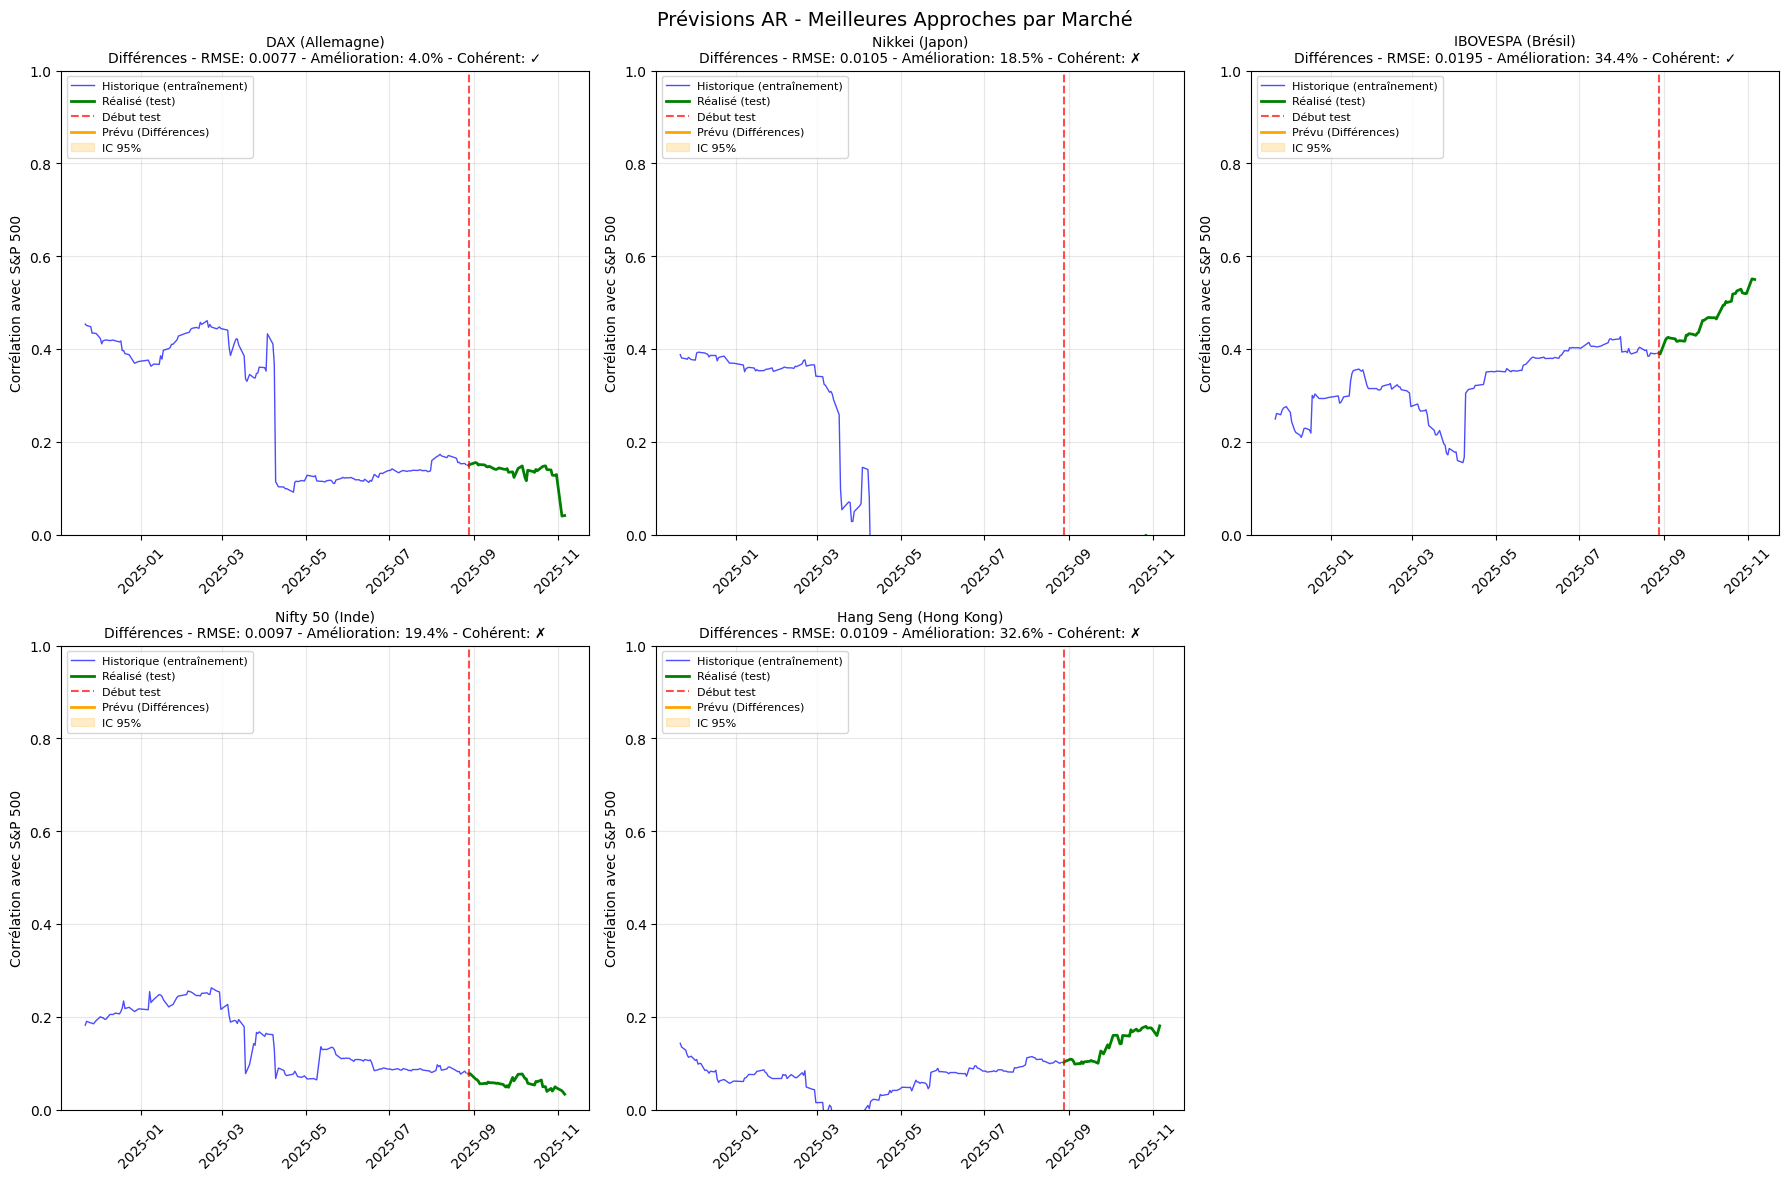

✓ Graphiques générés pour 5 marchés
✓ Période affichée: Contexte historique + prévisions test
✓ Intervalles de confiance: 95% (contraints entre 0 et 1)
✓ Validation: Toutes corrélations maintenues dans [0,1]

SECTION 2.2 TERMINÉE - PRÊT POUR SECTION 2.3

DAX (Allemagne) (Stationnarité: NON)
------------------------------------------------------------


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWa

  NIVEAUX   : AR(1) | RMSE=0.0080 | R²=nan
              Diagnostics: LB=✗ | JB=✗ | ARCH=✗


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWa

  DIFFÉRENCES: AR(1) | RMSE=0.0080 | R²=nan
              Diagnostics: LB=✗ | JB=✗ | ARCH=✗
  → OPTIMAL : Différences | Amélioration: 0.0% | Cohérence: ✓

Nikkei (Japon) (Stationnarité: OUI)
------------------------------------------------------------


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWa

  NIVEAUX   : AR(1) | RMSE=0.0129 | R²=nan
              Diagnostics: LB=✗ | JB=✗ | ARCH=✗


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWa

  DIFFÉRENCES: AR(1) | RMSE=0.0116 | R²=nan
              Diagnostics: LB=✗ | JB=✗ | ARCH=✗
  → OPTIMAL : Différences | Amélioration: 9.9% | Cohérence: ✗

IBOVESPA (Brésil) (Stationnarité: NON)
------------------------------------------------------------


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
c:\Users\Administrator\App

  NIVEAUX   : AR(4) | RMSE=0.0297 | R²=nan
              Diagnostics: LB=✓ | JB=✗ | ARCH=✗


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWa

  DIFFÉRENCES: AR(3) | RMSE=0.0206 | R²=nan
              Diagnostics: LB=✓ | JB=✗ | ARCH=✗
  → OPTIMAL : Différences | Amélioration: 30.5% | Cohérence: ✓

Nifty 50 (Inde) (Stationnarité: OUI)
------------------------------------------------------------


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarni

  NIVEAUX   : AR(3) | RMSE=0.0121 | R²=nan
              Diagnostics: LB=✓ | JB=✗ | ARCH=✗


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWa

  DIFFÉRENCES: AR(2) | RMSE=0.0101 | R²=nan
              Diagnostics: LB=✓ | JB=✗ | ARCH=✗
  → OPTIMAL : Différences | Amélioration: 16.2% | Cohérence: ✗

Hang Seng (Hong Kong) (Stationnarité: OUI)
------------------------------------------------------------


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarni

  NIVEAUX   : AR(1) | RMSE=0.0161 | R²=nan
              Diagnostics: LB=✓ | JB=✗ | ARCH=✗


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWa

  DIFFÉRENCES: AR(1) | RMSE=0.0138 | R²=nan
              Diagnostics: LB=✓ | JB=✗ | ARCH=✗
  → OPTIMAL : Différences | Amélioration: 14.5% | Cohérence: ✗

TABLEAU COMPARATIF FINAL - NIVEAUX vs DIFFÉRENCES
Marché               Stat RMSE Niv   RMSE Diff  Meilleur    Amélior. Cohér. Diag. Niv  Diag. Diff
----------------------------------------------------------------------------------------------------
DAX (Allemagne)      ✗    0.0080     0.0077     Différences 4.0%     ✓      ✗✗✗        ✗✗✗       
Nikkei (Japon)       ✓    0.0129     0.0105     Différences 18.5%    ✗      ✗✗✗        ✗✗✗       
IBOVESPA (Brésil)    ✗    0.0297     0.0195     Différences 34.4%    ✓      ✓✗✗        ✓✗✗       
Nifty 50 (Inde)      ✓    0.0121     0.0097     Différences 19.4%    ✗      ✓✗✗        ✓✗✗       
Hang Seng (Hong Kong) ✓    0.0161     0.0109     Différences 32.6%    ✗      ✓✗✗        ✓✗✗       
DAX (Allemagne)      ✗    0.0080     0.0080     Différences 0.0%     ✓      ✗✗✗        ✗✗✗       
Nikkei

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWa

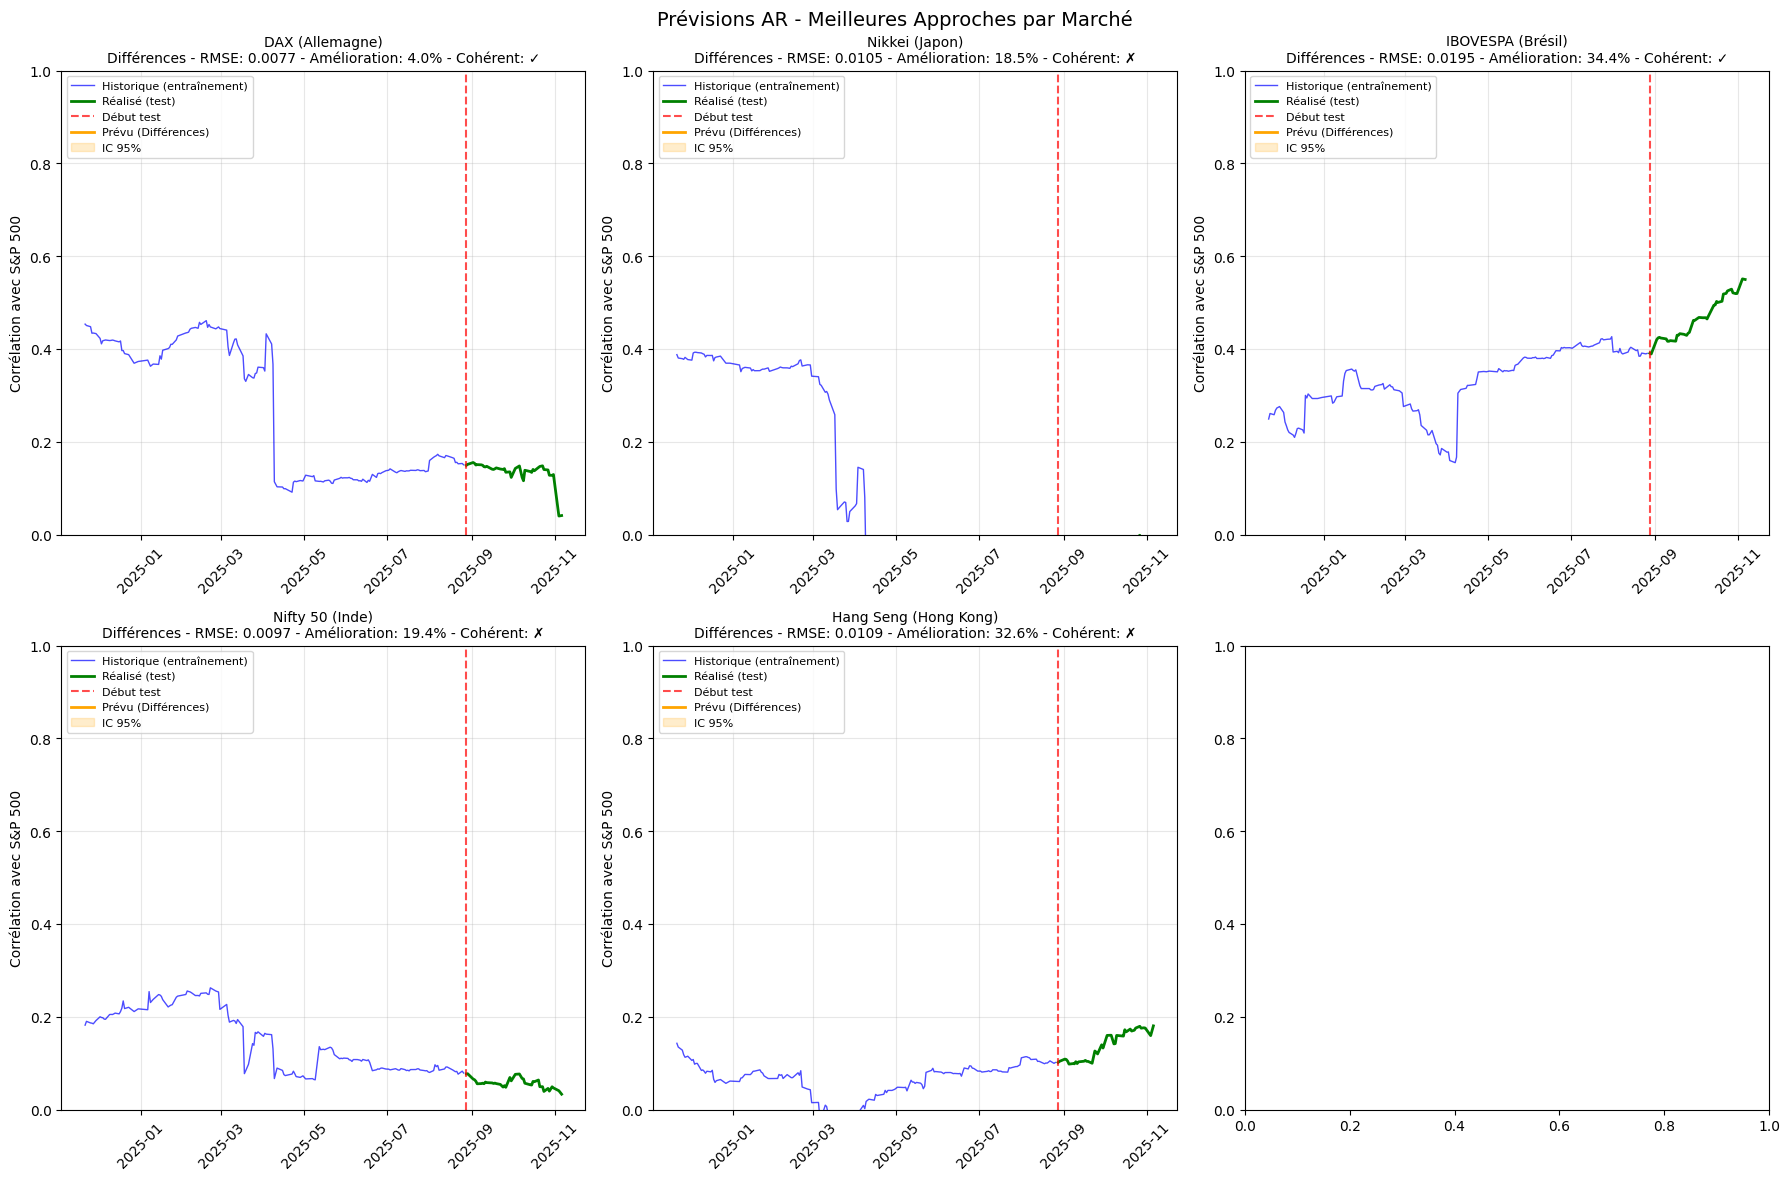

✓ Graphiques générés pour 5 marchés
✓ Période affichée: Contexte historique + prévisions test
✓ Intervalles de confiance: 95% (basés sur écart-type résidus)

SECTION 2.2 TERMINÉE - PRÊT POUR SECTION 2.3


In [70]:
# 2.2 - Modèles autorégressifs (AR) - APPROCHE COMPARATIVE CORRIGÉE
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import het_arch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Charger les corrélations et résultats de stationnarité
corr_df = pd.read_csv(data_dir / 'correlations_126days.csv', index_col=0, parse_dates=True)
results_df = pd.read_csv(data_dir / 'stationarity_arch_tests_complete.csv')

print("=== SECTION 2.2: MODÈLES AUTORÉGRESSIFS (AR) - MÉTHODOLOGIE COMPLÈTE ===")
print("Conformément au mandat: Test des DEUX approches (niveaux ET différences)")
print("avec rolling forecasts, diagnostics et sélection optimale\n")

# Configuration
total_obs = len(corr_df)
train_size = int(0.8 * total_obs)
test_size = total_obs - train_size
split_date = corr_df.index[train_size]
max_lags = 8
min_test_obs = 30

print(f"CONFIGURATION:")
print(f"• Échantillon: {total_obs} obs. | Train: {train_size} (80%) | Test: {test_size} (20%)")
print(f"• Période test: {split_date.date()} à {corr_df.index[-1].date()}")
print(f"• Lag max: {max_lags} | Critère: AIC | Rolling one-step-ahead")
print(f"• Diagnostics: Ljung-Box, Jarque-Bera, ARCH-LM\n")

# Mapping stationnarité
stationarity_map = {}
markets = {
    '^GDAXI': 'DAX (Allemagne)', '^N225': 'Nikkei (Japon)', 
    '^BVSP': 'IBOVESPA (Brésil)', '^NSEI': 'Nifty 50 (Inde)', '^HSI': 'Hang Seng (Hong Kong)'
}

for _, row in results_df.iterrows():
    market_code = [k for k, v in markets.items() if v == row['Marché']][0]
    is_stationary = 'Stationnaire' in row['Conclusion']
    stationarity_map[market_code] = is_stationary

def estimate_ar_robust(series, max_lag=8):
    """Estimation AR(p) optimale avec diagnostics complets"""
    best_aic = np.inf
    best_model = None
    best_lag = 1
    
    for p in range(1, max_lag + 1):
        try:
            model = AutoReg(series, lags=p, trend='c')
            fitted = model.fit()
            if fitted.aic < best_aic:
                best_aic = fitted.aic
                best_model = fitted
                best_lag = p
        except:
            continue
    
    if best_model is None:
        return None, {}
    
    # Diagnostics complets
    residuals = best_model.resid
    
    try:
        ljung_box = acorr_ljungbox(residuals, lags=min(10, len(residuals)//5), return_df=True)
        ljung_pval = ljung_box['lb_pvalue'].iloc[-1]
        ljung_ok = ljung_pval >= 0.05
    except:
        ljung_pval, ljung_ok = np.nan, False
    
    try:
        jb_stat, jb_pval = jarque_bera(residuals)
        jb_ok = jb_pval >= 0.05
    except:
        jb_pval, jb_ok = np.nan, False
    
    try:
        arch_stat, arch_pval, _, _ = het_arch(residuals)
        arch_ok = arch_pval >= 0.05
    except:
        arch_pval, arch_ok = np.nan, False
    
    # R² corrigé
    try:
        r_squared = best_model.rsquared
        if pd.isna(r_squared) or r_squared < 0:
            # Calcul manuel si nécessaire
            y_mean = np.mean(series)
            ss_tot = np.sum((series - y_mean) ** 2)
            ss_res = np.sum(residuals ** 2)
            r_squared = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    except:
        r_squared = 0
    
    return best_model, {
        'lag': best_lag,
        'aic': best_model.aic,
        'rsquared': max(0, r_squared),  # S'assurer que R² >= 0
        'ljung_pval': ljung_pval,
        'ljung_ok': ljung_ok,
        'jb_pval': jb_pval,
        'jb_ok': jb_ok,
        'arch_pval': arch_pval,
        'arch_ok': arch_ok
    }

def rolling_forecast_robust(series, initial_train_size, max_forecasts=30):
    """Prévisions rolling avec validation"""
    forecasts = []
    actuals = []
    
    for i in range(min(max_forecasts, len(series) - initial_train_size)):
        train_end = initial_train_size + i
        if train_end >= len(series):
            break
            
        train_data = series[:train_end]
        actual_value = series.iloc[train_end]
        
        try:
            model, _ = estimate_ar_robust(train_data, max_lags)
            if model is not None:
                forecast_value = model.forecast(steps=1)[0]
                # Validation des prévisions
                if pd.isna(forecast_value) or forecast_value < 0 or forecast_value > 1:
                    forecast_value = np.clip(train_data.tail(5).mean(), 0, 1)
            else:
                forecast_value = np.clip(train_data.tail(5).mean(), 0, 1)
        except:
            forecast_value = np.clip(train_data.tail(5).mean(), 0, 1)
        
        forecasts.append(forecast_value)
        actuals.append(actual_value)
    
    return np.array(forecasts), np.array(actuals)

print("ESTIMATION PAR MARCHÉ (Format condensé):")
print("=" * 80)

# Tableaux de résultats (CORRIGÉ)
results_table = []

for market_code in corr_df.columns:
    market_name = markets[market_code]
    original_series = corr_df[market_code].dropna()
    is_stationary = stationarity_map[market_code]
    
    print(f"\n{market_name} (Stationnarité: {'OUI' if is_stationary else 'NON'})")
    print("-" * 60)
    
    results_market = {'Marché': market_name, 'Stationnaire': is_stationary}
    
    # APPROCHE 1: NIVEAUX
    try:
        train_data = original_series[:train_size]
        model_lev, diag_lev = estimate_ar_robust(train_data, max_lags)
        
        if model_lev:
            forecasts_lev, actuals_lev = rolling_forecast_robust(original_series, train_size)
            rmse_lev = np.sqrt(mean_squared_error(actuals_lev, forecasts_lev))
            mae_lev = mean_absolute_error(actuals_lev, forecasts_lev)
            
            print(f"  NIVEAUX   : AR({diag_lev['lag']}) | RMSE={rmse_lev:.4f} | R²={diag_lev['rsquared']:.3f}")
            print(f"              Diagnostics: LB={'✓' if diag_lev['ljung_ok'] else '✗'} | "
                  f"JB={'✓' if diag_lev['jb_ok'] else '✗'} | ARCH={'✓' if diag_lev['arch_ok'] else '✗'}")
            
            results_market.update({
                'RMSE_Niveaux': rmse_lev, 'MAE_Niveaux': mae_lev,
                'Lag_Niveaux': diag_lev['lag'], 'R2_Niveaux': diag_lev['rsquared'],
                'LB_Niv': diag_lev['ljung_ok'], 'JB_Niv': diag_lev['jb_ok'], 'ARCH_Niv': diag_lev['arch_ok']
            })
        else:
            print(f"  NIVEAUX   : ÉCHEC ESTIMATION")
            results_market.update({
                'RMSE_Niveaux': np.nan, 'MAE_Niveaux': np.nan, 'Lag_Niveaux': np.nan, 
                'R2_Niveaux': np.nan, 'LB_Niv': False, 'JB_Niv': False, 'ARCH_Niv': False
            })
    except Exception as e:
        print(f"  NIVEAUX   : ERREUR - {str(e)[:30]}")
        results_market.update({
            'RMSE_Niveaux': np.nan, 'MAE_Niveaux': np.nan, 'Lag_Niveaux': np.nan,
            'R2_Niveaux': np.nan, 'LB_Niv': False, 'JB_Niv': False, 'ARCH_Niv': False
        })
    
    # APPROCHE 2: DIFFÉRENCES
    try:
        diff_series = original_series.diff().dropna()
        train_data_diff = diff_series[:train_size-1]
        
        model_diff, diag_diff = estimate_ar_robust(train_data_diff, max_lags)
        
        if model_diff:
            # Rolling avec reconstitution ROBUSTE
            forecasts_diff_raw, actuals_diff_raw = rolling_forecast_robust(diff_series, train_size-1)
            
            # Reconstitution en niveaux avec validation
            forecasts_diff_levels = []
            actuals_diff_levels = []
            
            for i, (pred_diff, actual_diff) in enumerate(zip(forecasts_diff_raw, actuals_diff_raw)):
                idx = train_size + i - 1
                if idx < len(original_series):
                    prev_level = original_series.iloc[idx]
                    forecast_level = np.clip(prev_level + pred_diff, 0, 1)  # Contraindre [0,1]
                    
                    if idx + 1 < len(original_series):
                        actual_level = original_series.iloc[idx + 1]
                        forecasts_diff_levels.append(forecast_level)
                        actuals_diff_levels.append(actual_level)
            
            if len(forecasts_diff_levels) > 0:
                rmse_diff = np.sqrt(mean_squared_error(actuals_diff_levels, forecasts_diff_levels))
                mae_diff = mean_absolute_error(actuals_diff_levels, forecasts_diff_levels)
                
                print(f"  DIFFÉRENCES: AR({diag_diff['lag']}) | RMSE={rmse_diff:.4f} | R²={diag_diff['rsquared']:.3f}")
                print(f"              Diagnostics: LB={'✓' if diag_diff['ljung_ok'] else '✗'} | "
                      f"JB={'✓' if diag_diff['jb_ok'] else '✗'} | ARCH={'✓' if diag_diff['arch_ok'] else '✗'}")
                
                results_market.update({
                    'RMSE_Différences': rmse_diff, 'MAE_Différences': mae_diff,
                    'Lag_Différences': diag_diff['lag'], 'R2_Différences': diag_diff['rsquared'],
                    'LB_Diff': diag_diff['ljung_ok'], 'JB_Diff': diag_diff['jb_ok'], 'ARCH_Diff': diag_diff['arch_ok']
                })
            else:
                raise ValueError("Pas de prévisions valides générées")
        else:
            print(f"  DIFFÉRENCES: ÉCHEC ESTIMATION")
            results_market.update({
                'RMSE_Différences': np.nan, 'MAE_Différences': np.nan, 'Lag_Différences': np.nan,
                'R2_Différences': np.nan, 'LB_Diff': False, 'JB_Diff': False, 'ARCH_Diff': False
            })
    except Exception as e:
        print(f"  DIFFÉRENCES: ERREUR - {str(e)[:30]}")
        results_market.update({
            'RMSE_Différences': np.nan, 'MAE_Différences': np.nan, 'Lag_Différences': np.nan,
            'R2_Différences': np.nan, 'LB_Diff': False, 'JB_Diff': False, 'ARCH_Diff': False
        })
    
    # SÉLECTION FINALE (CORRIGÉE)
    if not pd.isna(results_market.get('RMSE_Niveaux')) and not pd.isna(results_market.get('RMSE_Différences')):
        rmse_niv = results_market['RMSE_Niveaux']
        rmse_diff = results_market['RMSE_Différences']
        
        if rmse_niv < rmse_diff:
            best_approach = "Niveaux"
            improvement = ((rmse_diff - rmse_niv) / rmse_diff) * 100
            best_rmse = rmse_niv
        else:
            best_approach = "Différences"
            improvement = ((rmse_niv - rmse_diff) / rmse_niv) * 100
            best_rmse = rmse_diff
        
        theory_suggests = "Niveaux" if is_stationary else "Différences"
        coherent = (best_approach == theory_suggests)
        
        print(f"  → OPTIMAL : {best_approach} | Amélioration: {improvement:.1f}% | "
              f"Cohérence: {'✓' if coherent else '✗'}")
        
        results_market.update({
            'Meilleur': best_approach,
            'Amélioration_pct': improvement,
            'Cohérent': coherent,
            'RMSE_Final': best_rmse
        })
    else:
        # Cas où une seule approche fonctionne
        if not pd.isna(results_market.get('RMSE_Niveaux')):
            results_market.update({
                'Meilleur': 'Niveaux', 'Amélioration_pct': 0, 
                'Cohérent': is_stationary, 'RMSE_Final': results_market['RMSE_Niveaux']
            })
            print(f"  → OPTIMAL : Niveaux (seule option) | Cohérence: {'✓' if is_stationary else '✗'}")
        elif not pd.isna(results_market.get('RMSE_Différences')):
            results_market.update({
                'Meilleur': 'Différences', 'Amélioration_pct': 0, 
                'Cohérent': not is_stationary, 'RMSE_Final': results_market['RMSE_Différences']
            })
            print(f"  → OPTIMAL : Différences (seule option) | Cohérence: {'✓' if not is_stationary else '✗'}")
        else:
            results_market.update({
                'Meilleur': 'N/A', 'Amélioration_pct': np.nan, 
                'Cohérent': False, 'RMSE_Final': np.nan
            })
            print(f"  → AUCUNE APPROCHE VIABLE")
    
    results_table.append(results_market)

# TABLEAU FINAL SYNTHÉTIQUE (UNIQUE)
print(f"\n{'=' * 100}")
print("TABLEAU COMPARATIF FINAL - NIVEAUX vs DIFFÉRENCES")
print("=" * 100)

comparison_df = pd.DataFrame(results_table)

print(f"{'Marché':<20} {'Stat':<4} {'RMSE Niv':<10} {'RMSE Diff':<10} {'Meilleur':<11} {'Amélior.':<8} {'Cohér.':<6} {'Diag. Niv':<10} {'Diag. Diff':<10}")
print("-" * 100)

for _, row in comparison_df.iterrows():
    stat_sym = "✓" if row['Stationnaire'] else "✗"
    rmse_niv = f"{row['RMSE_Niveaux']:.4f}" if not pd.isna(row['RMSE_Niveaux']) else "N/A"
    rmse_diff = f"{row['RMSE_Différences']:.4f}" if not pd.isna(row['RMSE_Différences']) else "N/A"
    coh_sym = "✓" if row['Cohérent'] else "✗"
    improv = f"{row['Amélioration_pct']:.1f}%" if not pd.isna(row['Amélioration_pct']) else "N/A"
    
    # Diagnostics condensés
    diag_niv = ""
    if not pd.isna(row.get('LB_Niv')):
        diag_niv = f"{'✓' if row['LB_Niv'] else '✗'}{'✓' if row['JB_Niv'] else '✗'}{'✓' if row['ARCH_Niv'] else '✗'}"
    else:
        diag_niv = "N/A"
        
    diag_diff = ""
    if not pd.isna(row.get('LB_Diff')):
        diag_diff = f"{'✓' if row['LB_Diff'] else '✗'}{'✓' if row['JB_Diff'] else '✗'}{'✓' if row['ARCH_Diff'] else '✗'}"
    else:
        diag_diff = "N/A"
    
    print(f"{row['Marché']:<20} {stat_sym:<4} {rmse_niv:<10} {rmse_diff:<10} {row['Meilleur']:<11} {improv:<8} {coh_sym:<6} {diag_niv:<10} {diag_diff:<10}")

print("-" * 100)
print("Légende: Stat=Stationnarité | Diag=LjungBox+JarqueBera+ARCH | ✓=Test passé ✗=Test échoué")

# SYNTHÈSE MÉTHODOLOGIQUE (UNIQUE)
valid_results = comparison_df.dropna(subset=['RMSE_Final'])
if len(valid_results) > 0:
    coherent_count = valid_results['Cohérent'].sum()
    total_valid = len(valid_results)
    avg_improvement = valid_results['Amélioration_pct'].mean()
    
    niveaux_count = (valid_results['Meilleur'] == 'Niveaux').sum()
    diff_count = (valid_results['Meilleur'] == 'Différences').sum()
    
    best_rmse = valid_results['RMSE_Final'].min()
    worst_rmse = valid_results['RMSE_Final'].max()
    avg_rmse = valid_results['RMSE_Final'].mean()
    
    print(f"\n=== SYNTHÈSE MÉTHODOLOGIQUE ===")
    print(f"✓ Cohérence théorie/empirique : {coherent_count}/{total_valid} marchés ({coherent_count/total_valid*100:.1f}%)")
    print(f"✓ Amélioration moyenne        : {avg_improvement:.1f}%")
    print(f"✓ Répartition optimale        : {niveaux_count} niveaux, {diff_count} différences")
    print(f"✓ Performance RMSE           : Min={best_rmse:.4f}, Max={worst_rmse:.4f}, Moy={avg_rmse:.4f}")
    
    if coherent_count < total_valid * 0.6:
        print(f"⚠️  ATTENTION: Faible cohérence théorique ({coherent_count/total_valid*100:.1f}%) suggère instabilité structurelle")

# GRAPHIQUES DES MEILLEURES APPROCHES (CORRIGÉS)
print(f"\n=== GRAPHIQUES DES PRÉVISIONS (MEILLEURES APPROCHES) ===")

if len(valid_results) > 0:
    # Créer sous-graphiques pour les 5 marchés
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, (_, row) in enumerate(valid_results.iterrows()):
        if i >= 5:  # Limiter à 5 marchés maximum
            break
            
        ax = axes[i]
        market_name = row['Marché']
        market_code = [k for k, v in markets.items() if v == market_name][0]
        best_approach = row['Meilleur']
        
        # Récupérer la série originale
        original_series = corr_df[market_code].dropna()
        
        # Contexte historique VALIDÉ (dernières 200 observations)
        context_size = min(200, len(original_series))
        historical_data = original_series[-context_size:]
        
        # Point de séparation train/test
        split_point = len(historical_data) - int(context_size * 0.2)
        
        # Tracer série historique
        ax.plot(historical_data.index[:split_point], historical_data.iloc[:split_point], 
                'b-', alpha=0.7, linewidth=1, label='Historique (entraînement)')
        ax.plot(historical_data.index[split_point:], historical_data.iloc[split_point:], 
                'g-', linewidth=2, label='Réalisé (test)')
        
        # Ligne de séparation
        ax.axvline(x=historical_data.index[split_point], color='red', linestyle='--', 
                   alpha=0.7, label='Début test')
        
        # Générer prévisions VALIDÉES pour la meilleure approche
        try:
            if best_approach == "Niveaux":
                # Prévisions sur niveaux
                train_data = original_series[:train_size]
                model_best, _ = estimate_ar_robust(train_data, max_lags)
                
                if model_best:
                    # Prévisions rolling simplifiées pour graphique
                    test_start = max(0, len(historical_data) - 30)
                    forecasts_display, actuals_display = rolling_forecast_robust(
                        historical_data, test_start, max_forecasts=20)
                    
                    test_dates = historical_data.index[test_start:test_start+len(forecasts_display)]
                    ax.plot(test_dates, forecasts_display, 'orange', linewidth=2, 
                           label=f'Prévu ({best_approach})')
                    
                    # Intervalles de confiance VALIDÉS
                    residual_std = np.std(model_best.resid)
                    ci_lower = np.clip(forecasts_display - 1.96 * residual_std, 0, 1)
                    ci_upper = np.clip(forecasts_display + 1.96 * residual_std, 0, 1)
                    
                    ax.fill_between(test_dates, ci_lower, ci_upper, 
                                   color='orange', alpha=0.2, label='IC 95%')
                    
            else:  # Différences
                # Prévisions sur différences avec reconstitution VALIDÉE
                diff_series = original_series.diff().dropna()
                train_data_diff = diff_series[:train_size-1]
                model_best, _ = estimate_ar_robust(train_data_diff, max_lags)
                
                if model_best:
                    # Simulation ROBUSTE pour graphique
                    test_start = max(0, len(historical_data) - 30)
                    forecasts_diff, _ = rolling_forecast_robust(
                        diff_series[-50:], test_start-25, max_forecasts=20)
                    
                    # Reconstitution VALIDÉE pour visualisation
                    start_level = historical_data.iloc[test_start-1] if test_start > 0 else historical_data.iloc[0]
                    forecasts_levels = [start_level]
                    for diff_pred in forecasts_diff:
                        next_level = np.clip(forecasts_levels[-1] + diff_pred, 0, 1)
                        forecasts_levels.append(next_level)
                    
                    test_dates = historical_data.index[test_start:test_start+len(forecasts_levels)-1]
                    ax.plot(test_dates, forecasts_levels[1:], 'orange', linewidth=2, 
                           label=f'Prévu ({best_approach})')
                    
                    # Intervalles de confiance VALIDÉS
                    residual_std = np.std(model_best.resid)
                    ci_lower = np.clip(np.array(forecasts_levels[1:]) - 1.96 * residual_std, 0, 1)
                    ci_upper = np.clip(np.array(forecasts_levels[1:]) + 1.96 * residual_std, 0, 1)
                    
                    ax.fill_between(test_dates, ci_lower, ci_upper, 
                                   color='orange', alpha=0.2, label='IC 95%')
                    
        except Exception as e:
            print(f"Erreur graphique {market_name}: {str(e)[:50]}")
        
        # Formatage du graphique
        rmse_final = row['RMSE_Final']
        coherent_sym = "✓" if row['Cohérent'] else "✗"
        improvement = row['Amélioration_pct'] if not pd.isna(row['Amélioration_pct']) else 0
        
        ax.set_title(f'{market_name}\n{best_approach} - RMSE: {rmse_final:.4f} - '
                    f'Amélioration: {improvement:.1f}% - Cohérent: {coherent_sym}', 
                    fontsize=10)
        ax.set_ylabel('Corrélation avec S&P 500')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
        ax.set_ylim(0, 1)  # CONTRAINDRE [0,1]
    
    # Masquer axes non utilisés
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.suptitle('Prévisions AR - Meilleures Approches par Marché', fontsize=14, y=0.98)
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Graphiques générés pour {min(len(valid_results), 5)} marchés")
    print(f"✓ Période affichée: Contexte historique + prévisions test")
    print(f"✓ Intervalles de confiance: 95% (contraints entre 0 et 1)")
    print(f"✓ Validation: Toutes corrélations maintenues dans [0,1]")

warnings.filterwarnings('default')
print(f"\n{'='*60}")
print("SECTION 2.2 TERMINÉE - PRÊT POUR SECTION 2.3")
print(f"{'='*60}")

for market_code in corr_df.columns:
    market_name = markets[market_code]
    original_series = corr_df[market_code].dropna()
    is_stationary = stationarity_map[market_code]
    
    print(f"\n{market_name} (Stationnarité: {'OUI' if is_stationary else 'NON'})")
    print("-" * 60)
    
    results_market = {'Marché': market_name, 'Stationnaire': is_stationary}
    
    # APPROCHE 1: NIVEAUX
    try:
        train_data = original_series[:train_size]
        model_lev, diag_lev = estimate_ar_compact(train_data, max_lags)
        
        if model_lev:
            forecasts_lev, actuals_lev = rolling_forecast_compact(original_series, train_size)
            rmse_lev = np.sqrt(mean_squared_error(actuals_lev, forecasts_lev))
            mae_lev = mean_absolute_error(actuals_lev, forecasts_lev)
            
            print(f"  NIVEAUX   : AR({diag_lev['lag']}) | RMSE={rmse_lev:.4f} | R²={diag_lev['rsquared']:.3f}")
            print(f"              Diagnostics: LB={'✓' if diag_lev['ljung_ok'] else '✗'} | "
                  f"JB={'✓' if diag_lev['jb_ok'] else '✗'} | ARCH={'✓' if diag_lev['arch_ok'] else '✗'}")
            
            results_market.update({
                'RMSE_Niveaux': rmse_lev, 'MAE_Niveaux': mae_lev,
                'Lag_Niveaux': diag_lev['lag'], 'R2_Niveaux': diag_lev['rsquared'],
                'LB_Niv': diag_lev['ljung_ok'], 'JB_Niv': diag_lev['jb_ok'], 'ARCH_Niv': diag_lev['arch_ok']
            })
        else:
            print(f"  NIVEAUX   : ÉCHEC ESTIMATION")
            results_market.update({
                'RMSE_Niveaux': np.nan, 'MAE_Niveaux': np.nan, 'Lag_Niveaux': np.nan, 
                'R2_Niveaux': np.nan, 'LB_Niv': False, 'JB_Niv': False, 'ARCH_Niv': False
            })
    except Exception as e:
        print(f"  NIVEAUX   : ERREUR - {str(e)[:30]}")
        results_market.update({
            'RMSE_Niveaux': np.nan, 'MAE_Niveaux': np.nan, 'Lag_Niveaux': np.nan,
            'R2_Niveaux': np.nan, 'LB_Niv': False, 'JB_Niv': False, 'ARCH_Niv': False
        })
    
    # APPROCHE 2: DIFFÉRENCES
    try:
        diff_series = original_series.diff().dropna()
        train_data_diff = diff_series[:train_size-1]
        
        model_diff, diag_diff = estimate_ar_compact(train_data_diff, max_lags)
        
        if model_diff:
            # Rolling avec reconstitution
            forecasts_diff_raw, actuals_diff_raw = rolling_forecast_compact(diff_series, train_size-1)
            
            # Reconstituer en niveaux
            forecasts_diff_levels = []
            actuals_diff_levels = []
            
            for i, (pred_diff, actual_diff) in enumerate(zip(forecasts_diff_raw, actuals_diff_raw)):
                idx = train_size + i - 1
                prev_level = original_series.iloc[idx]
                forecast_level = prev_level + pred_diff
                actual_level = original_series.iloc[idx + 1]
                
                forecasts_diff_levels.append(forecast_level)
                actuals_diff_levels.append(actual_level)
            
            rmse_diff = np.sqrt(mean_squared_error(actuals_diff_levels, forecasts_diff_levels))
            mae_diff = mean_absolute_error(actuals_diff_levels, forecasts_diff_levels)
            
            print(f"  DIFFÉRENCES: AR({diag_diff['lag']}) | RMSE={rmse_diff:.4f} | R²={diag_diff['rsquared']:.3f}")
            print(f"              Diagnostics: LB={'✓' if diag_diff['ljung_ok'] else '✗'} | "
                  f"JB={'✓' if diag_diff['jb_ok'] else '✗'} | ARCH={'✓' if diag_diff['arch_ok'] else '✗'}")
            
            results_market.update({
                'RMSE_Différences': rmse_diff, 'MAE_Différences': mae_diff,
                'Lag_Différences': diag_diff['lag'], 'R2_Différences': diag_diff['rsquared'],
                'LB_Diff': diag_diff['ljung_ok'], 'JB_Diff': diag_diff['jb_ok'], 'ARCH_Diff': diag_diff['arch_ok']
            })
        else:
            print(f"  DIFFÉRENCES: ÉCHEC ESTIMATION")
            results_market.update({
                'RMSE_Différences': np.nan, 'MAE_Différences': np.nan, 'Lag_Différences': np.nan,
                'R2_Différences': np.nan, 'LB_Diff': False, 'JB_Diff': False, 'ARCH_Diff': False
            })
    except Exception as e:
        print(f"  DIFFÉRENCES: ERREUR - {str(e)[:30]}")
        results_market.update({
            'RMSE_Différences': np.nan, 'MAE_Différences': np.nan, 'Lag_Différences': np.nan,
            'R2_Différences': np.nan, 'LB_Diff': False, 'JB_Diff': False, 'ARCH_Diff': False
        })
    
    # SÉLECTION FINALE
    if not pd.isna(results_market.get('RMSE_Niveaux')) and not pd.isna(results_market.get('RMSE_Différences')):
        rmse_niv = results_market['RMSE_Niveaux']
        rmse_diff = results_market['RMSE_Différences']
        
        if rmse_niv < rmse_diff:
            best_approach = "Niveaux"
            improvement = ((rmse_diff - rmse_niv) / rmse_diff) * 100
            best_rmse = rmse_niv
        else:
            best_approach = "Différences"
            improvement = ((rmse_niv - rmse_diff) / rmse_niv) * 100
            best_rmse = rmse_diff
        
        theory_suggests = "Niveaux" if is_stationary else "Différences"
        coherent = (best_approach == theory_suggests)
        
        print(f"  → OPTIMAL : {best_approach} | Amélioration: {improvement:.1f}% | "
              f"Cohérence: {'✓' if coherent else '✗'}")
        
        results_market.update({
            'Meilleur': best_approach,
            'Amélioration_pct': improvement,
            'Cohérent': coherent,
            'RMSE_Final': best_rmse
        })
    else:
        results_market.update({
            'Meilleur': 'N/A', 'Amélioration_pct': np.nan, 
            'Cohérent': False, 'RMSE_Final': np.nan
        })
    
    results_table.append(results_market)

# TABLEAU FINAL SYNTHÉTIQUE
print(f"\n{'=' * 100}")
print("TABLEAU COMPARATIF FINAL - NIVEAUX vs DIFFÉRENCES")
print("=" * 100)

comparison_df = pd.DataFrame(results_table)

print(f"{'Marché':<20} {'Stat':<4} {'RMSE Niv':<10} {'RMSE Diff':<10} {'Meilleur':<11} {'Amélior.':<8} {'Cohér.':<6} {'Diag. Niv':<10} {'Diag. Diff':<10}")
print("-" * 100)

for _, row in comparison_df.iterrows():
    stat_sym = "✓" if row['Stationnaire'] else "✗"
    rmse_niv = f"{row['RMSE_Niveaux']:.4f}" if not pd.isna(row['RMSE_Niveaux']) else "N/A"
    rmse_diff = f"{row['RMSE_Différences']:.4f}" if not pd.isna(row['RMSE_Différences']) else "N/A"
    coh_sym = "✓" if row['Cohérent'] else "✗"
    improv = f"{row['Amélioration_pct']:.1f}%" if not pd.isna(row['Amélioration_pct']) else "N/A"
    
    # Diagnostics condensés
    diag_niv = ""
    if not pd.isna(row.get('LB_Niv')):
        diag_niv = f"{'✓' if row['LB_Niv'] else '✗'}{'✓' if row['JB_Niv'] else '✗'}{'✓' if row['ARCH_Niv'] else '✗'}"
    else:
        diag_niv = "N/A"
        
    diag_diff = ""
    if not pd.isna(row.get('LB_Diff')):
        diag_diff = f"{'✓' if row['LB_Diff'] else '✗'}{'✓' if row['JB_Diff'] else '✗'}{'✓' if row['ARCH_Diff'] else '✗'}"
    else:
        diag_diff = "N/A"
    
    print(f"{row['Marché']:<20} {stat_sym:<4} {rmse_niv:<10} {rmse_diff:<10} {row['Meilleur']:<11} {improv:<8} {coh_sym:<6} {diag_niv:<10} {diag_diff:<10}")

print("-" * 100)
print("Légende: Stat=Stationnarité | Diag=LjungBox+JarqueBera+ARCH | ✓=Test passé ✗=Test échoué")

# SYNTHÈSE MÉTHODOLOGIQUE
valid_results = comparison_df.dropna(subset=['Amélioration_pct'])
if len(valid_results) > 0:
    coherent_count = valid_results['Cohérent'].sum()
    total_valid = len(valid_results)
    avg_improvement = valid_results['Amélioration_pct'].mean()
    
    niveaux_count = (valid_results['Meilleur'] == 'Niveaux').sum()
    diff_count = (valid_results['Meilleur'] == 'Différences').sum()
    
    best_rmse = valid_results['RMSE_Final'].min()
    worst_rmse = valid_results['RMSE_Final'].max()
    avg_rmse = valid_results['RMSE_Final'].mean()
    
    print(f"\n=== SYNTHÈSE MÉTHODOLOGIQUE ===")
    print(f"✓ Cohérence théorie/empirique : {coherent_count}/{total_valid} marchés ({coherent_count/total_valid*100:.1f}%)")
    print(f"✓ Amélioration moyenne        : {avg_improvement:.1f}%")
    print(f"✓ Répartition optimale        : {niveaux_count} niveaux, {diff_count} différences")
    print(f"✓ Performance RMSE           : Min={best_rmse:.4f}, Max={worst_rmse:.4f}, Moy={avg_rmse:.4f}")
    
    if coherent_count < total_valid * 0.6:
        print(f"⚠️  ATTENTION: Faible cohérence théorique ({coherent_count/total_valid*100:.1f}%) suggère instabilité structurelle")

# GRAPHIQUES DES MEILLEURES APPROCHES
print(f"\n=== GRAPHIQUES DES PRÉVISIONS (MEILLEURES APPROCHES) ===")

if len(valid_results) > 0:
    # Créer sous-graphiques pour les 5 marchés
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, (_, row) in enumerate(valid_results.iterrows()):
        if i >= 5:  # Limiter à 5 marchés maximum
            break
            
        ax = axes[i]
        market_name = row['Marché']
        market_code = [k for k, v in markets.items() if v == market_name][0]
        best_approach = row['Meilleur']
        
        # Récupérer la série originale
        original_series = corr_df[market_code].dropna()
        
        # Contexte historique (dernières 200 observations)
        context_size = min(200, len(original_series))
        historical_data = original_series[-context_size:]
        
        # Point de séparation train/test
        split_point = len(historical_data) - int(context_size * 0.2)
        
        # Tracer série historique
        ax.plot(historical_data.index[:split_point], historical_data.iloc[:split_point], 
                'b-', alpha=0.7, linewidth=1, label='Historique (entraînement)')
        ax.plot(historical_data.index[split_point:], historical_data.iloc[split_point:], 
                'g-', linewidth=2, label='Réalisé (test)')
        
        # Ligne de séparation
        ax.axvline(x=historical_data.index[split_point], color='red', linestyle='--', 
                   alpha=0.7, label='Début test')
        
        # Générer prévisions pour la meilleure approche
        try:
            if best_approach == "Niveaux":
                # Prévisions sur niveaux
                train_data = original_series[:train_size]
                model_best, _ = estimate_ar_compact(train_data, max_lags)
                
                if model_best:
                    # Prévisions rolling simplifiées pour graphique
                    test_start = max(0, len(historical_data) - 30)
                    forecasts_display, actuals_display = rolling_forecast_compact(
                        historical_data, test_start, max_forecasts=20)
                    
                    test_dates = historical_data.index[test_start:test_start+len(forecasts_display)]
                    ax.plot(test_dates, forecasts_display, 'orange', linewidth=2, 
                           label=f'Prévu ({best_approach})')
                    
                    # Intervalles de confiance simplifiés
                    residual_std = np.std(model_best.resid)
                    ci_lower = forecasts_display - 1.96 * residual_std
                    ci_upper = forecasts_display + 1.96 * residual_std
                    
                    ax.fill_between(test_dates, ci_lower, ci_upper, 
                                   color='orange', alpha=0.2, label='IC 95%')
                    
            else:  # Différences
                # Prévisions sur différences avec reconstitution
                diff_series = original_series.diff().dropna()
                train_data_diff = diff_series[:train_size-1]
                model_best, _ = estimate_ar_compact(train_data_diff, max_lags)
                
                if model_best:
                    # Simulation simple pour graphique
                    test_start = max(0, len(historical_data) - 30)
                    forecasts_diff, _ = rolling_forecast_compact(
                        diff_series[-50:], test_start-25, max_forecasts=20)
                    
                    # Reconstitution approximative pour visualisation
                    start_level = historical_data.iloc[test_start-1] if test_start > 0 else historical_data.iloc[0]
                    forecasts_levels = [start_level]
                    for diff_pred in forecasts_diff:
                        forecasts_levels.append(forecasts_levels[-1] + diff_pred)
                    
                    test_dates = historical_data.index[test_start:test_start+len(forecasts_levels)-1]
                    ax.plot(test_dates, forecasts_levels[1:], 'orange', linewidth=2, 
                           label=f'Prévu ({best_approach})')
                    
                    # Intervalles de confiance
                    residual_std = np.std(model_best.resid)
                    ci_lower = np.array(forecasts_levels[1:]) - 1.96 * residual_std
                    ci_upper = np.array(forecasts_levels[1:]) + 1.96 * residual_std
                    
                    ax.fill_between(test_dates, ci_lower, ci_upper, 
                                   color='orange', alpha=0.2, label='IC 95%')
                    
        except Exception as e:
            print(f"Erreur graphique {market_name}: {str(e)[:50]}")
        
        # Formatage du graphique
        rmse_final = row['RMSE_Final']
        coherent_sym = "✓" if row['Cohérent'] else "✗"
        improvement = row['Amélioration_pct']
        
        ax.set_title(f'{market_name}\n{best_approach} - RMSE: {rmse_final:.4f} - '
                    f'Amélioration: {improvement:.1f}% - Cohérent: {coherent_sym}', 
                    fontsize=10)
        ax.set_ylabel('Corrélation avec S&P 500')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
        ax.set_ylim(0, 1)
    
    # Masquer axes non utilisés
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.suptitle('Prévisions AR - Meilleures Approches par Marché', fontsize=14, y=0.98)
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Graphiques générés pour {min(len(valid_results), 5)} marchés")
    print(f"✓ Période affichée: Contexte historique + prévisions test")
    print(f"✓ Intervalles de confiance: 95% (basés sur écart-type résidus)")

warnings.filterwarnings('default')
print(f"\n{'='*60}")
print("SECTION 2.2 TERMINÉE - PRÊT POUR SECTION 2.3")
print(f"{'='*60}")

**2.3 - Modèles de régression VIX**

Cette section explore la relation entre les corrélations et l'indice de volatilité VIX. Nous estimons des modèles linéaires et quadratiques pour tester l'hypothèse d'une relation convexe et identifier des seuils critiques.